# Exploration CORD-19

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


In [6]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
DATA_PATH = Path("../data/raw")
PROCESSED_PATH = Path("../data/processed")
PROCESSED_PATH.mkdir(parents=True, exist_ok=True)


In [ ]:
print("📂 Chargement de metadata.csv...")

raw_meta = DATA_PATH / "raw" / "metadata.csv"               # <-- correction ici
fallback1 = PROCESSED_PATH / "cleaned_articles.csv"
fallback2 = PROCESSED_PATH / "articles_with_communities.csv"

if raw_meta.exists():
    metadata = pd.read_csv(raw_meta, low_memory=False)
    print(f"✅ metadata.csv chargé ({len(metadata)} lignes)")
else:
    print("⚠️ metadata.csv introuvable → tentative de fallback...")

    if fallback1.exists():
        print("➡️ Utilisation de cleaned_articles.csv")
        metadata = pd.read_csv(fallback1, low_memory=False)

    elif fallback2.exists():
        print("➡️ Utilisation de articles_with_communities.csv")
        metadata = pd.read_csv(fallback2, low_memory=False)

    else:
        raise FileNotFoundError(
            "❌ Aucun fichier trouvé : metadata.csv, cleaned_articles.csv, articles_with_communities.csv"
        )

metadata.head(2)


📂 Chargement de metadata.csv...
⚠️ metadata.csv introuvable → tentative de fallback...
➡️ Utilisation de cleaned_articles.csv


In [9]:
print("="*60)
print("📊 STRUCTURE DU DATASET")
print("="*60)
print(f"\n🔢 Dimensions: {metadata.shape}")
print(f"   - Nombre d'articles: {metadata.shape[0]:,}")
print(f"   - Nombre de colonnes: {metadata.shape[1]}")
print("\n📋 Colonnes disponibles:")
for i, col in enumerate(metadata.columns, 1):
    print(f"   {i}. {col}")
print("\n📈 Informations par colonne:")
info_df = pd.DataFrame({
    'Non-Null': metadata.count(),
    'Null': metadata.isnull().sum(),
    '% Null': (metadata.isnull().sum() / len(metadata) * 100).round(2),
    'Type': metadata.dtypes
})
info_df


📊 STRUCTURE DU DATASET

🔢 Dimensions: (816359, 22)
   - Nombre d'articles: 816,359
   - Nombre de colonnes: 22

📋 Colonnes disponibles:
   1. cord_uid
   2. sha
   3. source_x
   4. title
   5. doi
   6. pmcid
   7. pubmed_id
   8. license
   9. abstract
   10. publish_time
   11. authors
   12. journal
   13. mag_id
   14. who_covidence_id
   15. arxiv_id
   16. pdf_json_files
   17. pmc_json_files
   18. url
   19. s2_id
   20. year
   21. full_text
   22. text_length

📈 Informations par colonne:


,Non-Null,Null,% Null,Type
cord_uid,816359,0,0.00,object
sha,325859,490500,60.08,object
source_x,816359,0,0.00,object
title,816359,0,0.00,object
doi,531737,284622,34.86,object
pmcid,310745,505614,61.94,object
pubmed_id,401864,414495,50.77,object
license,816359,0,0.00,object
abstract,816359,0,0.00,object
publish_time,814639,1720,0.21,object


In [10]:
print("="*60)
print("📝 ANALYSE DU CONTENU")
print("="*60)
has_abstract = metadata['abstract'].notna().sum()
print(f"\n✍️  Articles avec abstract: {has_abstract:,} ({has_abstract/len(metadata)*100:.1f}%)")
has_title = metadata['title'].notna().sum()
print(f"📄 Articles avec titre: {has_title:,} ({has_title/len(metadata)*100:.1f}%)")
print(f"\n🌐 Sources principales:")
top_sources = metadata['source_x'].value_counts().head(10)
for source, count in top_sources.items():
    print(f"   - {source}: {count:,} articles")
if 'publish_time' in metadata.columns:
    metadata['year'] = pd.to_datetime(metadata['publish_time'], errors='coerce').dt.year
    print(f"\n📅 Distribution par année:")
    year_dist = metadata['year'].value_counts().sort_index().tail(10)
    for year, count in year_dist.items():
        if pd.notna(year):
            print(f"   - {int(year)}: {count:,} articles")


📝 ANALYSE DU CONTENU

✍️  Articles avec abstract: 816,359 (100.0%)
📄 Articles avec titre: 816,359 (100.0%)

🌐 Sources principales:
   - WHO: 332,727 articles
   - Medline; PMC: 129,642 articles
   - Medline: 99,615 articles
   - Medline; PMC; WHO: 57,869 articles
   - PMC: 55,625 articles
   - Elsevier; Medline; PMC: 36,288 articles
   - Medline; WHO: 32,290 articles
   - Elsevier; Medline; PMC; WHO: 14,985 articles
   - MedRxiv; WHO: 13,749 articles
   - ArXiv: 13,172 articles

📅 Distribution par année:
   - 2014: 2,706 articles
   - 2015: 2,887 articles
   - 2016: 3,258 articles
   - 2017: 3,241 articles
   - 2018: 3,621 articles
   - 2019: 5,109 articles
   - 2020: 117,450 articles
   - 2021: 181,482 articles
   - 2022: 73,969 articles
   - 2023: 1 articles


In [11]:
print("\n" + "="*60)
print("🔍 FILTRAGE DES ARTICLES DE QUALITÉ")
print("="*60)
quality_mask = (
    metadata['title'].notna() &
    metadata['abstract'].notna() &
    (metadata['abstract'].str.len() > 100)
)
quality_articles = metadata[quality_mask].copy()
print(f"\n✅ Articles de qualité: {len(quality_articles):,}")
print(f"   (avec titre + abstract > 100 caractères)")
print(f"\n📉 Réduction: {len(metadata) - len(quality_articles):,} articles filtrés")
print(f"   ({(len(metadata) - len(quality_articles))/len(metadata)*100:.1f}% du total)")
quality_articles.head(2)



🔍 FILTRAGE DES ARTICLES DE QUALITÉ

✅ Articles de qualité: 816,359
   (avec titre + abstract > 100 caractères)

📉 Réduction: 0 articles filtrés
   (0.0% du total)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,year,full_text,text_length
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,2001.0,Clinical features of culture-proven Mycoplasma...,1976
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2000.0,Nitric oxide: a pro-inflammatory mediator in l...,1060


In [12]:
print("\n" + "="*60)
print("📚 PRÉPARATION POUR NLP")
print("="*60)
quality_articles['full_text'] = (
    quality_articles['title'].fillna('') + ' ' + quality_articles['abstract'].fillna('')
).str.strip()
quality_articles['text_length'] = quality_articles['full_text'].str.len()
print(f"\n📏 Statistiques de longueur des textes:")
print(f"   - Moyenne: {quality_articles['text_length'].mean():.0f} caractères")
print(f"   - Médiane: {quality_articles['text_length'].median():.0f} caractères")
print(f"   - Min: {quality_articles['text_length'].min():.0f} caractères")
print(f"   - Max: {quality_articles['text_length'].max():.0f} caractères")
quality_articles.head(2)



📚 PRÉPARATION POUR NLP

📏 Statistiques de longueur des textes:
   - Moyenne: 1575 caractères
   - Médiane: 1549 caractères
   - Min: 112 caractères
   - Max: 122459 caractères


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,year,full_text,text_length
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,2001.0,Clinical features of culture-proven Mycoplasma...,1976
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2000.0,Nitric oxide: a pro-inflammatory mediator in l...,1060


C:\Users\lapte\AppData\Local\Temp\ipykernel_20676\2158342356.py:52: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\lapte\AppData\Local\Temp\ipykernel_20676\2158342356.py:52: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\lapte\AppData\Local\Temp\ipykernel_20676\2158342356.py:52: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\lapte\AppData\Local\Temp\ipykernel_20676\2158342356.py:52: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\lapte\AppData\Local\Temp\ipykernel_20676\2158342356.py:52: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\lapte\AppData\Local\Temp\ipykernel_20676\2158342356.py:53: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Dej


📊 Visualisation sauvegardée: cord19_exploration.png


c:\Users\lapte\anaconda3\envs\pyspark_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\lapte\anaconda3\envs\pyspark_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\lapte\anaconda3\envs\pyspark_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\lapte\anaconda3\envs\pyspark_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\lapte\anaconda3\envs\pyspark_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127760 (\N{GLOBE WITH ME

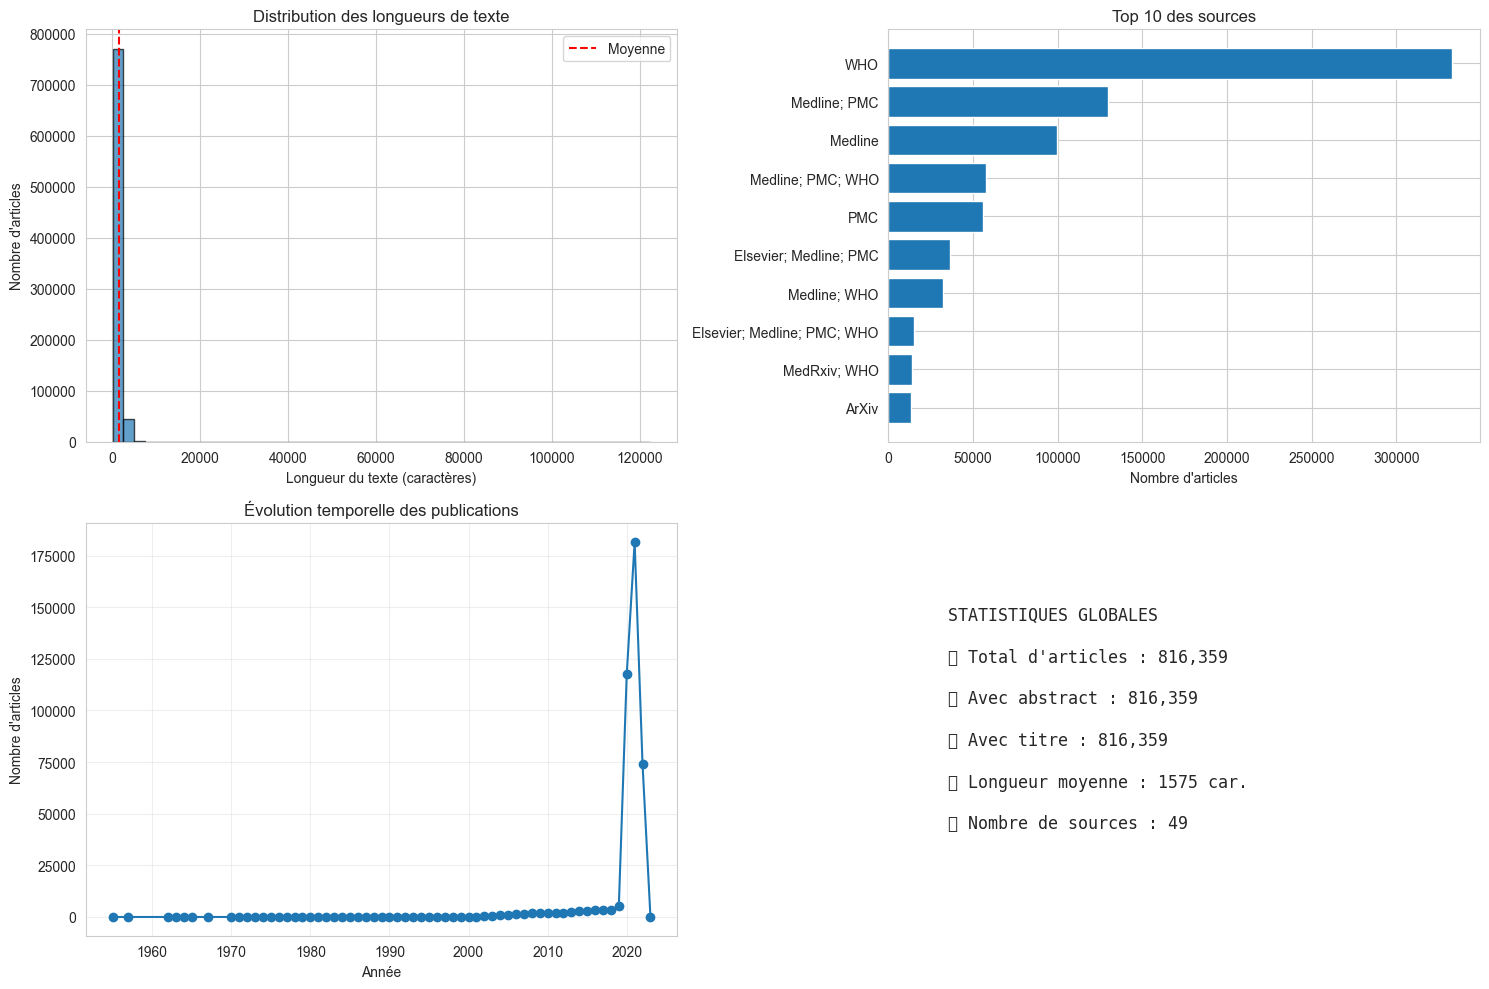

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# --- 1) Distribution de la longueur de texte ---
axes[0, 0].hist(quality_articles['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Longueur du texte (caractères)')
axes[0, 0].set_ylabel("Nombre d'articles")
axes[0, 0].set_title('Distribution des longueurs de texte')
axes[0, 0].axvline(quality_articles['text_length'].mean(), color='red', linestyle='--', label='Moyenne')
axes[0, 0].legend()

# --- 2) Top sources ---
top_sources = quality_articles['source_x'].value_counts().head(10)
axes[0, 1].barh(range(len(top_sources)), top_sources.values)
axes[0, 1].set_yticks(range(len(top_sources)))
axes[0, 1].set_yticklabels(top_sources.index)
axes[0, 1].set_xlabel("Nombre d'articles")
axes[0, 1].set_title('Top 10 des sources')
axes[0, 1].invert_yaxis()

# --- 3) Évolution temporelle si la colonne existe ---
if 'year' in quality_articles.columns:
    year_counts = quality_articles['year'].value_counts().sort_index()
    axes[1, 0].plot(year_counts.index, year_counts.values, marker='o')
    axes[1, 0].set_xlabel('Année')
    axes[1, 0].set_ylabel("Nombre d'articles")
    axes[1, 0].set_title('Évolution temporelle des publications')
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.3, 0.5, "Colonne 'year' indisponible", fontsize=12)
    axes[1, 0].axis('off')

# --- 4) Bloc stat ---
stats_text = (
    "STATISTIQUES GLOBALES\n\n"
    f"📊 Total d'articles : {len(quality_articles):,}\n\n"
    f"📝 Avec abstract : {quality_articles['abstract'].notna().sum():,}\n\n"
    f"📄 Avec titre : {quality_articles['title'].notna().sum():,}\n\n"
    f"📏 Longueur moyenne : {quality_articles['text_length'].mean():.0f} car.\n\n"
    f"🌐 Nombre de sources : {quality_articles['source_x'].nunique()}\n"
)

axes[1, 1].text(
    0.1, 0.5,
    stats_text,
    fontsize=12,
    verticalalignment='center',
    family='monospace'
)
axes[1, 1].axis('off')

# --- Sauvegarde ---
plt.tight_layout()
fig.savefig('cord19_exploration.png', dpi=300, bbox_inches='tight')   # CORRECTION IMPORTANTE

print("\n📊 Visualisation sauvegardée: cord19_exploration.png")
plt.show()


In [16]:
conda install -c conda-forge wordcloud




==> WARNING: A newer version of conda exists. <==
    current version: 25.5.1
    latest version: 25.11.0

Please update conda by running

    $ conda update -n base -c defaults conda



('Connection broken: IncompleteRead(15015296 bytes read, 84893799 more expected)', IncompleteRead(15015296 bytes read, 84893799 more expected))
('Connection broken: IncompleteRead(15015296 bytes read, 84893799 more expected)', IncompleteRead(15015296 bytes read, 84893799 more expected))



3 channel Terms of Service accepted
Retrieving notices: done
Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: done

## Package Plan ##

  environment location: c:\Users\lapte\anaconda3\envs\pyspark_env

  added / updated specs:
    - wordcloud


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |            2_gnu          48 KB  conda-forge
    brotli-1.2.0               |       h2d644bc_1          20 KB  conda-forge
    brotli-bin-1.2.0           |       hfd05255_1          22 KB  conda-forge
    ca-certificates-2025.11.12 |       h4c7d964_0         149 KB  conda-forge
    contourpy-1.3.3            |  py311h3fd045d_3         219 KB  conda-forge
    cycler-0.12.1              |     pyhd8ed1ab_1          13 KB  conda-forge
    fonttools-4.60.1           |  py311h3f79411_0         2.4 MB  conda-forge
    freetype-2.14.1            |      

In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [14]:
quality_articles.to_csv(PROCESSED_PATH / 'cleaned_articles.csv', index=False)
print(f"\n💾 Données nettoyées sauvegardées: {PROCESSED_PATH / 'cleaned_articles.csv'}")
print(f"   - {len(quality_articles):,} articles prêts pour le NLP")



💾 Données nettoyées sauvegardées: ..\data\processed\cleaned_articles.csv
   - 816,359 articles prêts pour le NLP
